# Data Set: Arrest Data
The goal of our project is finding the most dangerous and safest neighborhoods in Pittsburgh. We'll use three data sets to use as a metric to determine this, arrest data, non-traffic citations, and police reported crime. The information we'll use from this data is the number of such incidents of each for each neighborhood. We thought it'd be interesting to see statistically where the most dangerous areas of Pittsburgh are.
Also used: Total Population (per Neighborhood in Pittsburgh)

https://data.wprdc.org/dataset/arrest-data

https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/82f29015-6905-4b1c-8300-afe9bb2231b3/download/total-population.csv

Max Wong

In [2]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline

In [9]:
arrests = pd.read_csv("arrests.csv")

arrests['ARRESTTIME'] = pd.to_datetime(arrests['ARRESTTIME'])

arrests = arrests[arrests['ARRESTTIME'].dt.year.isin([2022, 2023])]

The dataset we are dealing with logs every arrest from when it started logging arrests on August 1, 2016 to November 14, 2023. We'll cut down the data to the 2 most recent years, in 2022 and 2023. We will then count up the number of arrests each neighborhood in Pittsburgh has to determine the safest and most dangerous neighborhoods.

In [10]:
# Neighborhoods by number of arrests
arrest_count = arrests["INCIDENTNEIGHBORHOOD"].value_counts().rename_axis('neighborhood').reset_index(name='arrests')
arrest_count.sort_values(ascending=False, by='arrests')
# 41. South Oakland 521
# 45. North Oakland 455
# 50. Central Oakland 354
# 52. West Oakland 325

,neighborhood,arrests
0,Central Business District,1173
1,South Side Flats,715
2,East Allegheny,474
3,Carrick,439
4,East Liberty,405
...,...,...
89,Regent Square,9
90,Ridgemont,9
91,East Carnegie,5
92,New Homestead,4


Here are the top 10 neighborhoods with the most arrests:

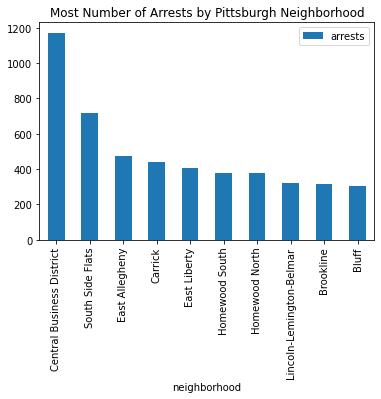

In [11]:
arrest_count.head(10).plot(x='neighborhood', kind='bar', title='Most Number of Arrests by Pittsburgh Neighborhood') 

# Data from 1998 but consistent data spans August 1, 2016 to November 14, 2023

And the 10 least:

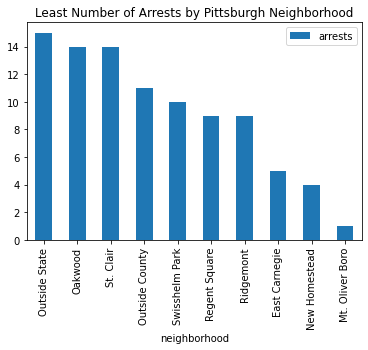

In [12]:
arrest_count.tail(10).plot(x='neighborhood', kind='bar', title='Least Number of Arrests by Pittsburgh Neighborhood')

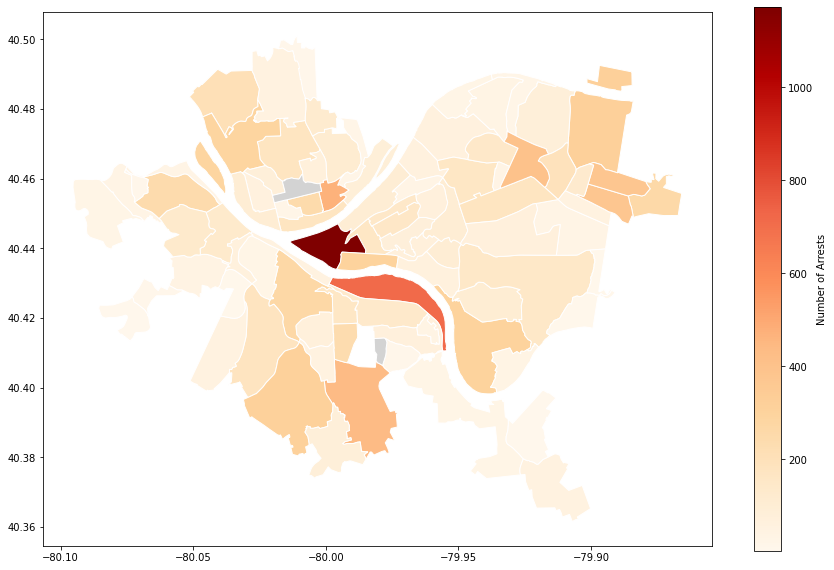

In [23]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
arrest_map = neighborhoods.merge(arrest_count, how='left', left_on='hood', right_on='neighborhood')
arrest_map.plot(column='arrests',
               cmap='OrRd',              
               edgecolor="white",      
               legend=True,           
               legend_kwds={'label': "Number of Arrests"}, 
               figsize=(15, 10),      
               missing_kwds={"color": "lightgrey"}) 

It can be said however that the base statistic of the number of arrests/offenses in a neighborhood can't tell the whole story. Let's see the population of each neighborhood in Pittsburgh for some context:

In [14]:
# Population by Neighborhood
population = pd.read_csv("total-population.csv")
population.sort_values(by='Estimate; Total', ascending=False)

,Neighborhood,Id,Estimate; Total,Margin of Error; Total
77,Squirrel Hill South,78,16042.0,889.712313
68,Shadyside,69,13562.0,861.984919
13,Brookline,14,13160.0,943.065215
76,Squirrel Hill North,77,11336.0,767.783173
15,Carrick,16,10122.0,826.666196
...,...,...,...,...
78,St. Clair,79,270.0,96.000000
87,West End,88,235.0,138.000000
57,North Shore,58,205.0,66.753277
71,South Shore,72,12.0,14.000000


Now let's merge the arrests and the population so that we can eventually use this data in a geopandas map plot:

In [24]:
arrests_by_population = population.merge(arrest_count, left_on='Neighborhood', right_on='neighborhood')
arrests_by_population = arrests_by_population.sort_values(by='arrests', ascending=False)
arrests_by_population

,Neighborhood,Id,Estimate; Total,Margin of Error; Total,neighborhood,arrests
16,Central Business District,17,4060.0,458.026200,Central Business District,1173
69,South Side Flats,73,6292.0,747.592135,South Side Flats,715
24,East Allegheny,26,2095.0,284.401125,East Allegheny,474
15,Carrick,16,10122.0,826.666196,Carrick,439
27,East Liberty,29,5537.0,612.871112,East Liberty,405
...,...,...,...,...,...,...
79,Swisshelm Park,83,1345.0,106.000000,Swisshelm Park,10
64,Ridgemont,68,314.0,109.000000,Ridgemont,9
63,Regent Square,67,1033.0,101.000000,Regent Square,9
25,East Carnegie,27,610.0,120.000000,East Carnegie,5


Here are the neighborhoods on a scatterplot:

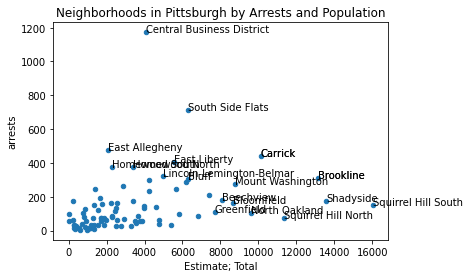

In [28]:
most_populated = arrests_by_population.sort_values(by='Estimate; Total', ascending=False).head(10)
most_arrests = arrests_by_population.sort_values(by='arrests', ascending=False).head(10
                                                                                    )
plot = arrests_by_population.plot(kind='scatter', x='Estimate; Total', y='arrests', title='Neighborhoods in Pittsburgh by Arrests and Population')
for idx, row in most_populated.iterrows():
    plot.annotate(row['neighborhood'], (row['Estimate; Total'], row['arrests']))
for idx, row in most_arrests.iterrows():
    plot.annotate(row['neighborhood'], (row['Estimate; Total'], row['arrests']))

Now to find a metric to get a geopandas map out of this data; let's use arrests per capita. 

I found that some neighborhoods in Pittsburgh are completely industrial or commercial and have no houses, such as Chateau with a population of 3 (somehow), or North Shore that is a huge commercial and entertainment district, and its little population wouldn't do it's size justice.  This would result in neighborhoods that would have a skewed arrests per capita. 

For this reason, I've only added the arrests per capita statistic to neighborhoods with a population of over 500, which eliminates 10 of the neighborhoods that are solely industrial, commercial, and some of the residential districts that have such a small sample size.

In [30]:
arrests_per_capita = []
for index, row in arrests_by_population.iterrows():
    # Use arrests per capita data for neighborhoods with at least 500 population
    if row['Estimate; Total'] >= 500:
        arrests_per_capita.append(row['arrests']/row['Estimate; Total'])
    else:
        arrests_per_capita.append(0)

arrests_by_population['Arrests per Capita'] = arrests_per_capita
arrests_by_population

,Neighborhood,Id,Estimate; Total,Margin of Error; Total,neighborhood,arrests,Arrests per Capita
16,Central Business District,17,4060.0,458.026200,Central Business District,1173,0.288916
69,South Side Flats,73,6292.0,747.592135,South Side Flats,715,0.113636
24,East Allegheny,26,2095.0,284.401125,East Allegheny,474,0.226253
15,Carrick,16,10122.0,826.666196,Carrick,439,0.043371
27,East Liberty,29,5537.0,612.871112,East Liberty,405,0.073144
...,...,...,...,...,...,...,...
79,Swisshelm Park,83,1345.0,106.000000,Swisshelm Park,10,0.007435
64,Ridgemont,68,314.0,109.000000,Ridgemont,9,0.000000
63,Regent Square,67,1033.0,101.000000,Regent Square,9,0.008712
25,East Carnegie,27,610.0,120.000000,East Carnegie,5,0.008197


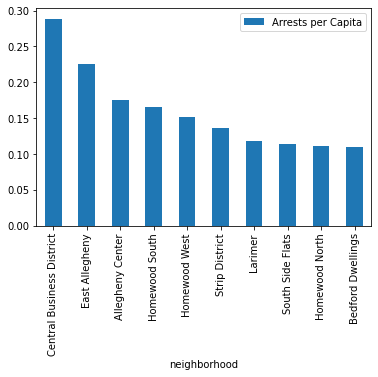

In [31]:
per_capita_sorted = arrests_by_population.sort_values(by='Arrests per Capita', ascending=False)
per_capita_sorted.head(10).plot(x='neighborhood', y='Arrests per Capita', kind='bar')

North Oakland is the 11th safest neighborhood in Pittsburgh by this metric!

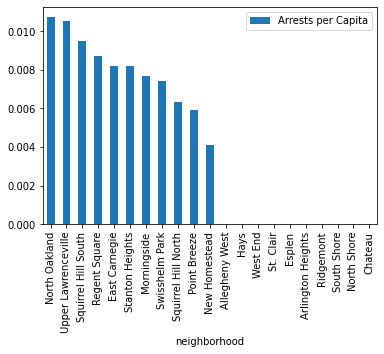

In [32]:
per_capita_sorted.tail(21).plot(x='neighborhood', y='Arrests per Capita', kind='bar')

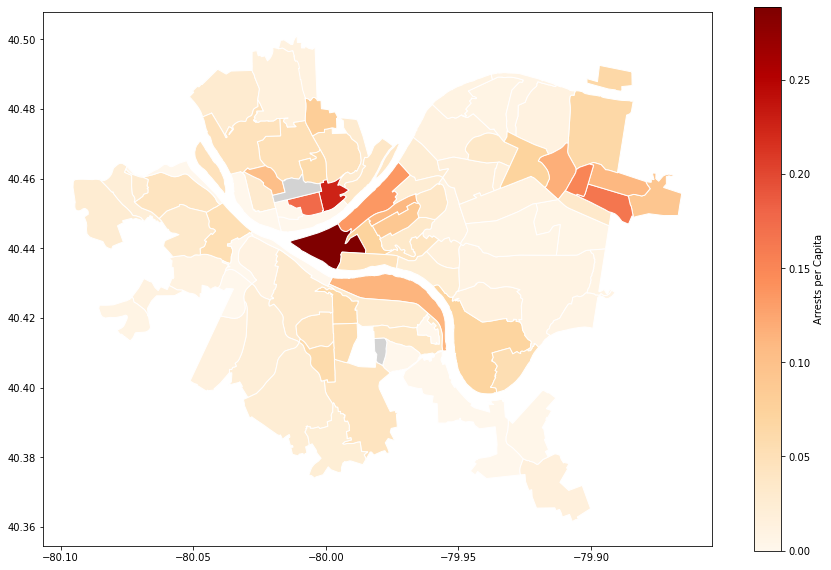

In [33]:
arrest_map = neighborhoods.merge(arrests_by_population, how='left', left_on='hood', right_on='neighborhood')
arrest_map.plot(column='Arrests per Capita',
               cmap='OrRd',              
               edgecolor="white",      
               legend=True,           
               legend_kwds={'label': "Arrests per Capita"}, 
               figsize=(15, 10),      
               missing_kwds={"color": "lightgrey"}) 